In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.profile_performance as profile_performance
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000

In [ ]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/HepG2/HepG2_training_paths.json"
num_tasks = 2
use_controls = False
model_class = profile_models.ProfilePredictorWithoutControls

In [ ]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/K562/K562_training_paths.json"
num_tasks = 7
use_controls = False
model_class = profile_models.ProfilePredictorWithoutControls

In [3]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/profile/config/SPI1/SPI1_training_paths.json"
num_tasks = 4
use_controls = True
model_class = profile_models.ProfilePredictorWithControls

In [28]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/profile/config/E2F6/E2F6_training_paths.json"
num_tasks = 2
use_controls = True
model_class = profile_models.ProfilePredictorWithControls

In [29]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [30]:
# Import the model without priors
noprior_model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/E2F6_keep1/9/model_ckpt_epoch_6.pt"
noprior_model = model_util.restore_model(model_class, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device)

In [39]:
# Import the model with priors
prior_model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/E2F6_prior_keep1/29/model_ckpt_epoch_9.pt"
prior_model = model_util.restore_model(model_class, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device)

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [32]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [33]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [10]:
def predict_coords(
    model, coords, fourier_att_prior_freq_limit=160,
    fourier_att_prior_freq_limit_softness=None, print_losses=True
):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset,
    the input gradients, and the loss values. The returned profiles are in terms
    of raw counts, and the returned counts are also raw. Returned values are all
    NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    if use_controls:
        true_profs = profiles[:, :num_tasks, :, :]
        cont_profs = profiles[:, num_tasks:, :, :]
    else:
        true_profs, cont_profs = profiles, None

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, 0, 20, 50,
            None, 1, 3, fourier_att_prior_freq_limit,
            fourier_att_prior_freq_limit_softness, False, input_grads, status
    )
    prof_loss, count_loss, att_loss = \
        prof_loss.item(), count_loss.item(), att_loss.item()
    if print_losses:
        print("Profile loss\tCounts loss\tPrior loss")
        print("%6.3f\t%6.3f\t%6.3f" % (prof_loss, count_loss, att_loss))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), \
        true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np, \
        prof_loss, count_loss, att_loss

In [11]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### Computing/plotting Fourier transforms

In [12]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [13]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()

### Compare the performance between the two conditions

In [ ]:
# Draw a sample of coordinates, and compute the profile NLL and attribution prior loss
# of each coordinate for both models
coords = []
noprior_prof_nll_values, noprior_att_loss_values = [], []
prior_prof_nll_values, prior_att_loss_values = [], []

# Sample from chr8 and chr10
sample = pos_coords_table[pos_coords_table[0].isin(["chr8", "chr10"])].sample(500).values[:, :3]

for row in tqdm.tqdm(sample):
    chrom, start, end = row
    
    _, _, _, _, _, _, prof_loss, _, att_loss = predict_coords(
        noprior_model, [(chrom, start, end)], print_losses=False
    )
    noprior_prof_nll_values.append(prof_loss)
    noprior_att_loss_values.append(att_loss)
    
    _, _, _, _, _, _, prof_loss, _, att_loss = predict_coords(
        prior_model, [(chrom, start, end)], print_losses=False
    )
    prior_prof_nll_values.append(prof_loss)
    prior_att_loss_values.append(att_loss)
    
    coords.append((chrom, start, end))

In [ ]:
# Plot histogram of these values over both conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(
    [noprior_prof_nll_values, prior_prof_nll_values],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
ax[0].set_title("Histogram of validation profile loss over a subset of examples")
ax[0].set_xlabel("Validation profile loss")
ax[0].legend()
ax[1].hist(
    [noprior_att_loss_values, prior_att_loss_values],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
ax[1].set_title("Histogram of attribution prior loss over a subset of examples")
ax[1].set_xlabel("Attribution prior loss")
ax[1].legend()
plt.tight_layout()

In [ ]:
# Plot histogram of values DIFFERENCE over both conditions
prof_nll_diffs = np.array(noprior_prof_nll_values) - np.array(prior_prof_nll_values)
att_loss_diffs = np.array(noprior_att_loss_values) - np.array(prior_att_loss_values)
bin_num = 30

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(prof_nll_diffs, bin_num, histtype="bar", color="purple")
ax[0].set_title("Histogram of difference in validation profile loss")
ax[0].set_xlabel("Validation profile loss, without priors - with priors")
ax[1].hist(att_loss_diffs, bin_num, histtype="bar", color="purple")
ax[1].set_title("Histogram of difference in attribution prior loss")
ax[1].set_xlabel("Attribution prior loss, without priors - with priors")
plt.tight_layout()

### View predictions

In [27]:
def predict_and_plot(model, chrom, start, end, seq_slice=slice(650, 750)):
    log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads, \
        prof_loss, count_loss, att_loss = predict_coords(model, [(chrom, start, end)] * 50)

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    plot_profiles(pred_prof_probs[0], true_prof_probs[0])

    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=200)
    viz_sequence.plot_weights(input_grads[0][seq_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])

In [34]:
pos_coords_table[pos_coords_table[0].isin(["chr8", "chr10"])].sample(10)

,0,1,2,3,4,5,6,7,8,9
8154,chr10,17026688,17027018,.,693,.,19.34150,-1.0,4.84269,165
19252,chr10,79068755,79068918,.,1000,.,38.83121,-1.0,4.84269,75
31461,chr10,97334913,97335232,.,1000,.,197.99780,-1.0,4.84269,155
1275,chr8,89757754,89758084,.,862,.,8.11207,-1.0,2.76967,165
30367,chr8,144826528,144826928,.,1000,.,142.25931,-1.0,4.84269,233
3815,chr10,71851018,71851348,.,674,.,14.49138,-1.0,4.84269,165
21706,chr10,71812075,71812205,.,1000,.,47.20087,-1.0,4.84269,98
22302,chr10,32958371,32958587,.,1000,.,49.65338,-1.0,4.84269,110
11719,chr8,123768164,123768494,.,949,.,23.83520,-1.0,4.84269,165
12668,chr10,70563299,70563629,.,843,.,25.22295,-1.0,4.84269,165


Profile loss	Counts loss	Prior loss
271.204	 0.753	 0.400


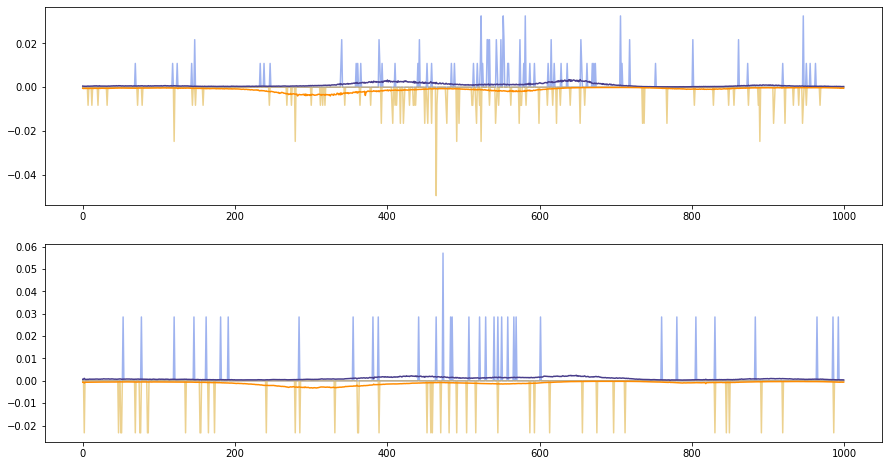

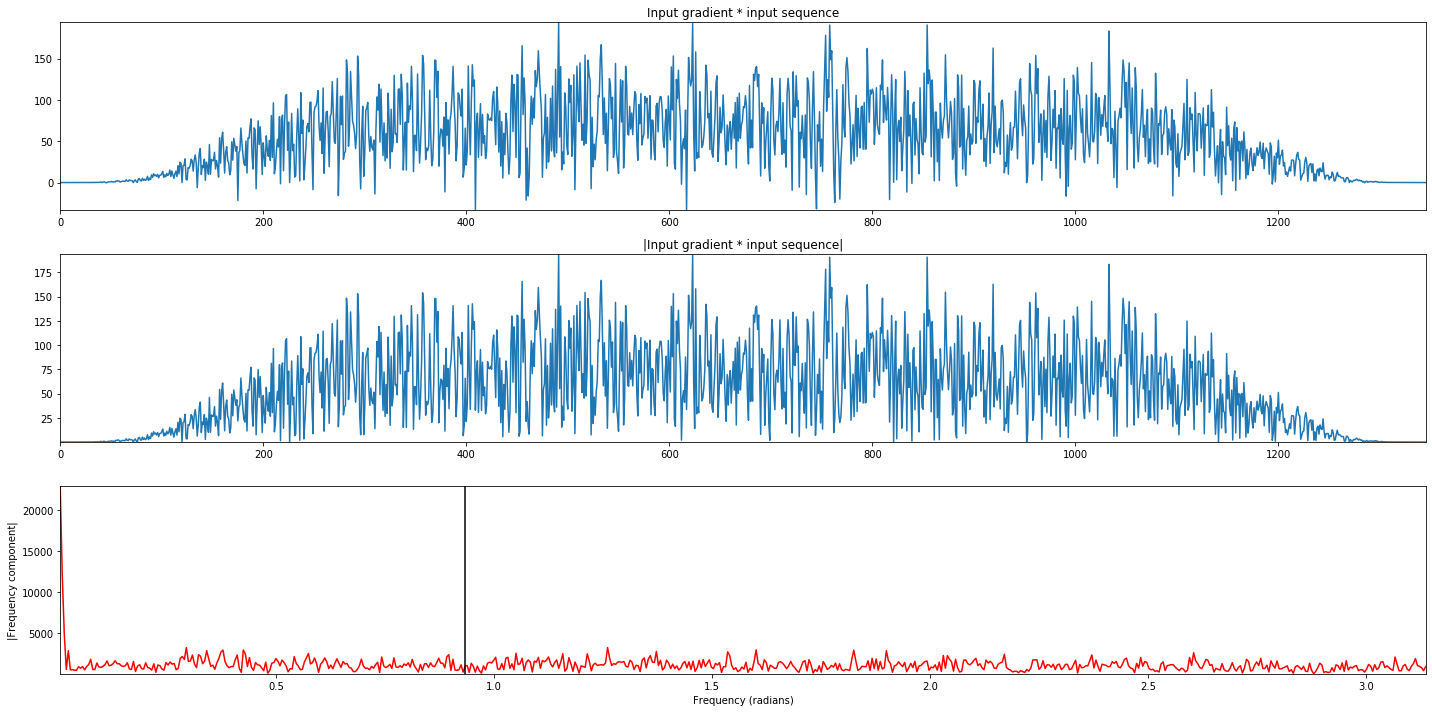

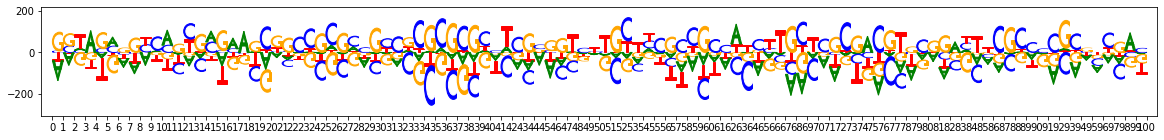

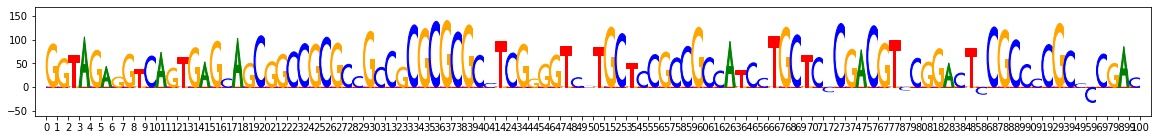

Profile loss	Counts loss	Prior loss
290.069	 3.522	 0.315


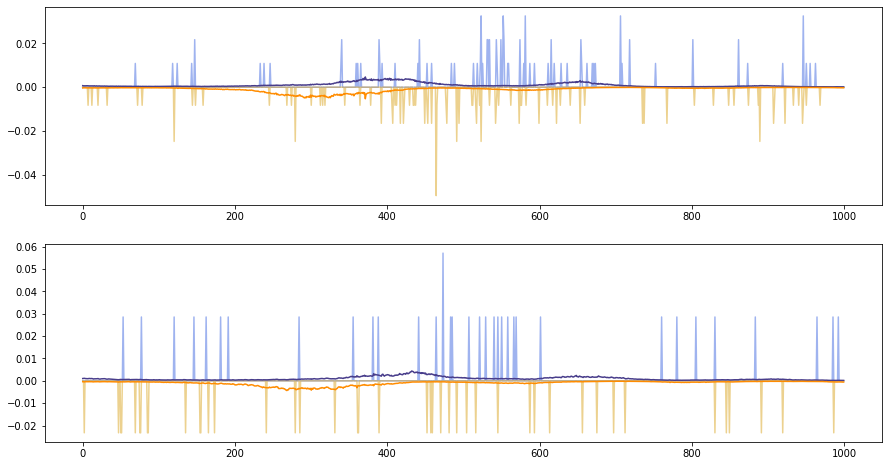

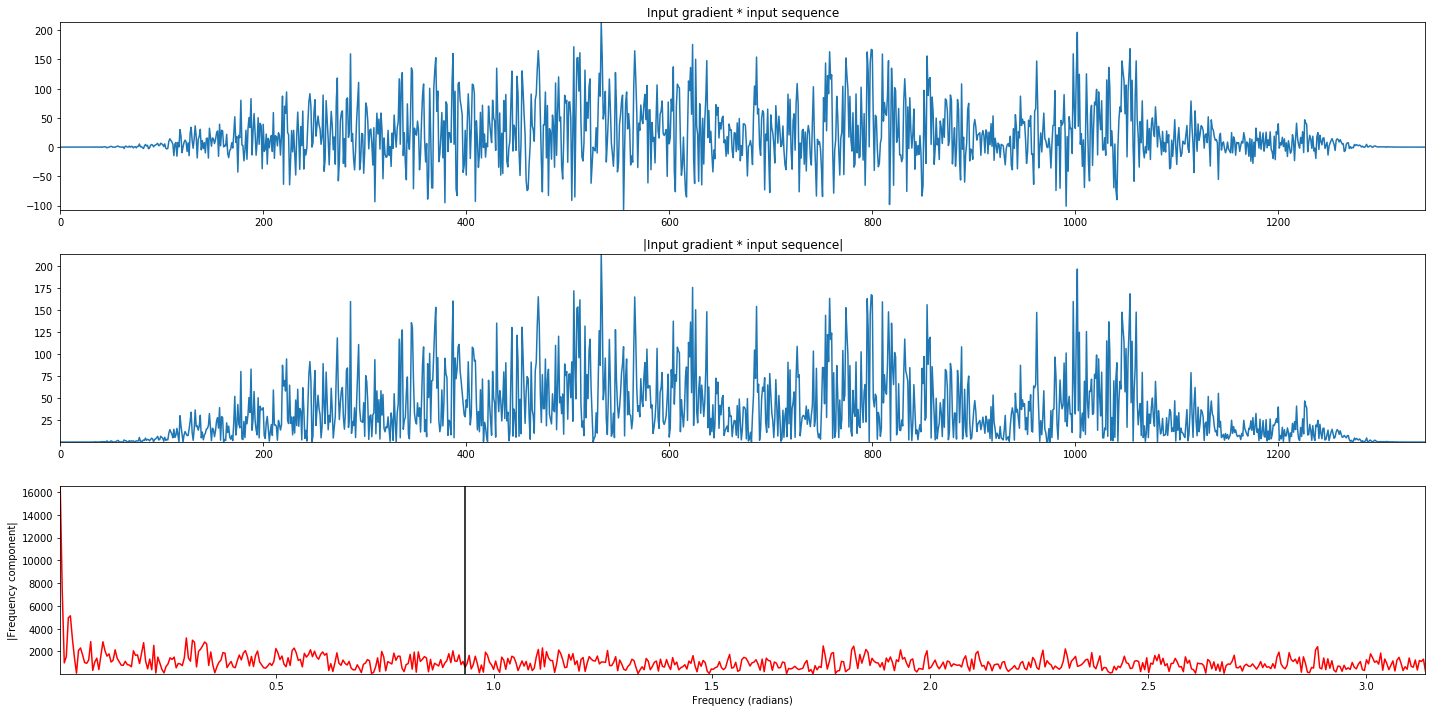

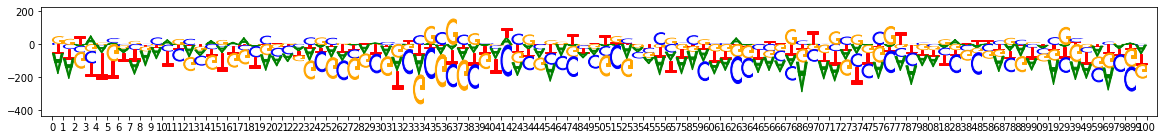

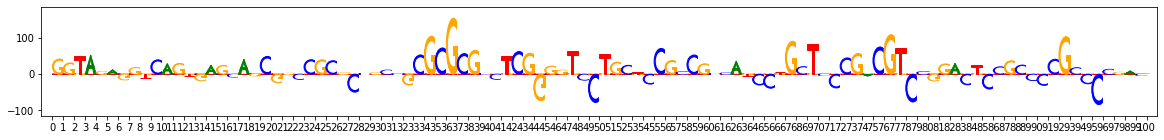

In [36]:
# E2F6
chrom, start, end = "chr8", 143578221, 143578333
seq_slice = slice(650, 750)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

Profile loss	Counts loss	Prior loss
521.851	 0.886	 0.383


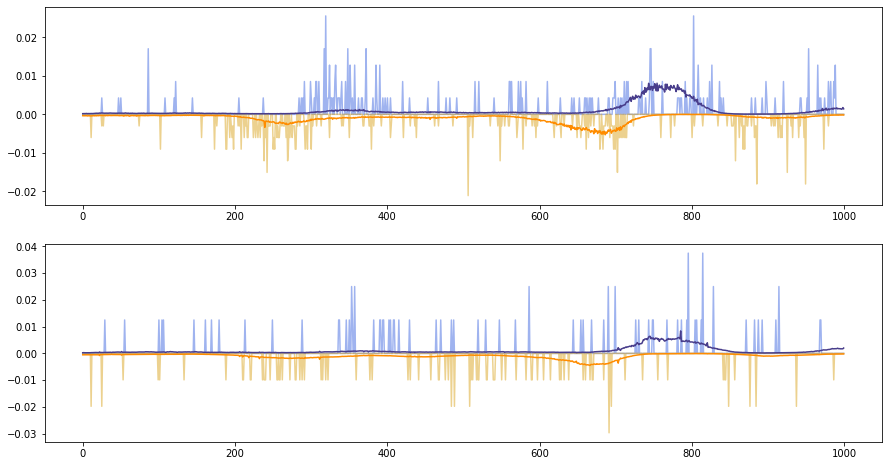

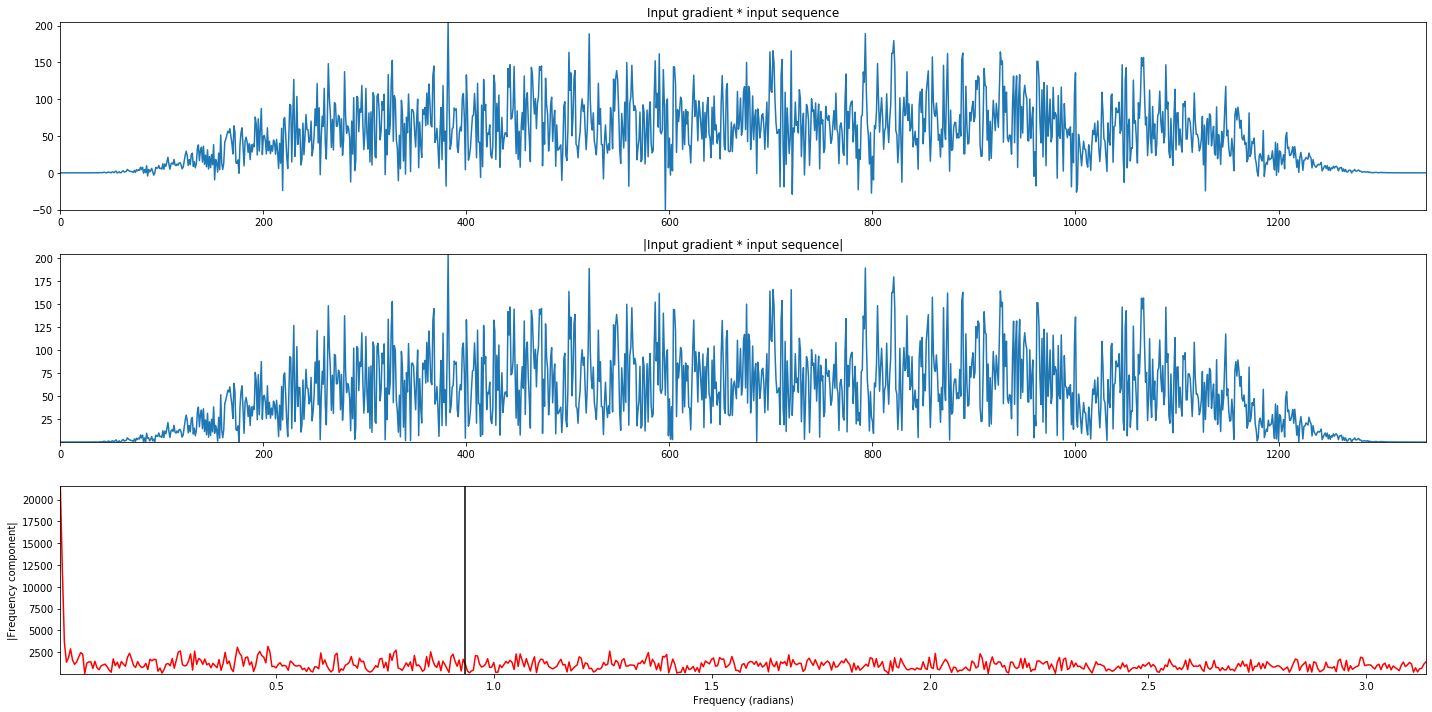

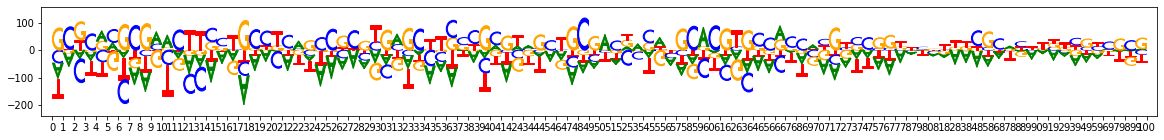

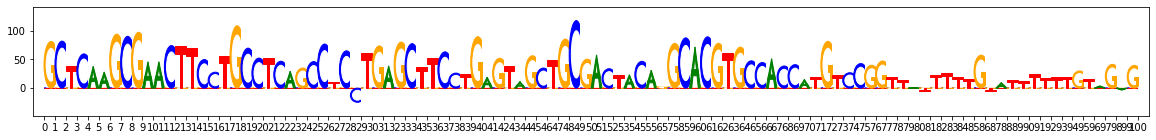

Profile loss	Counts loss	Prior loss
558.100	 1.043	 0.298


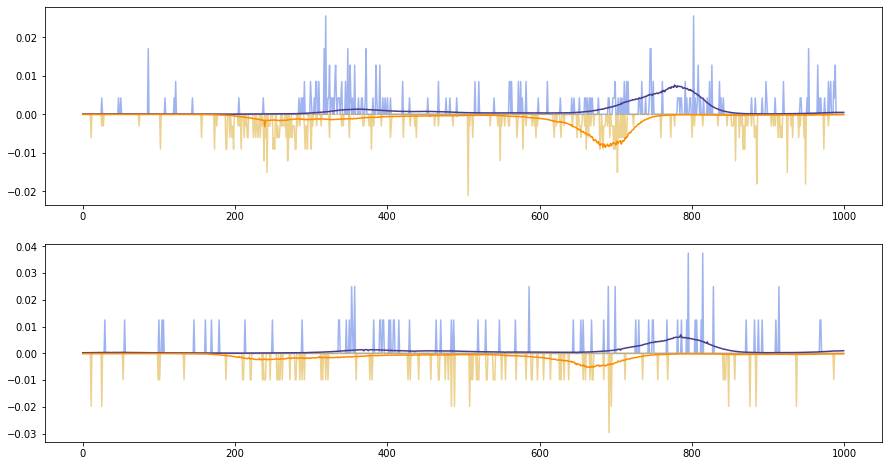

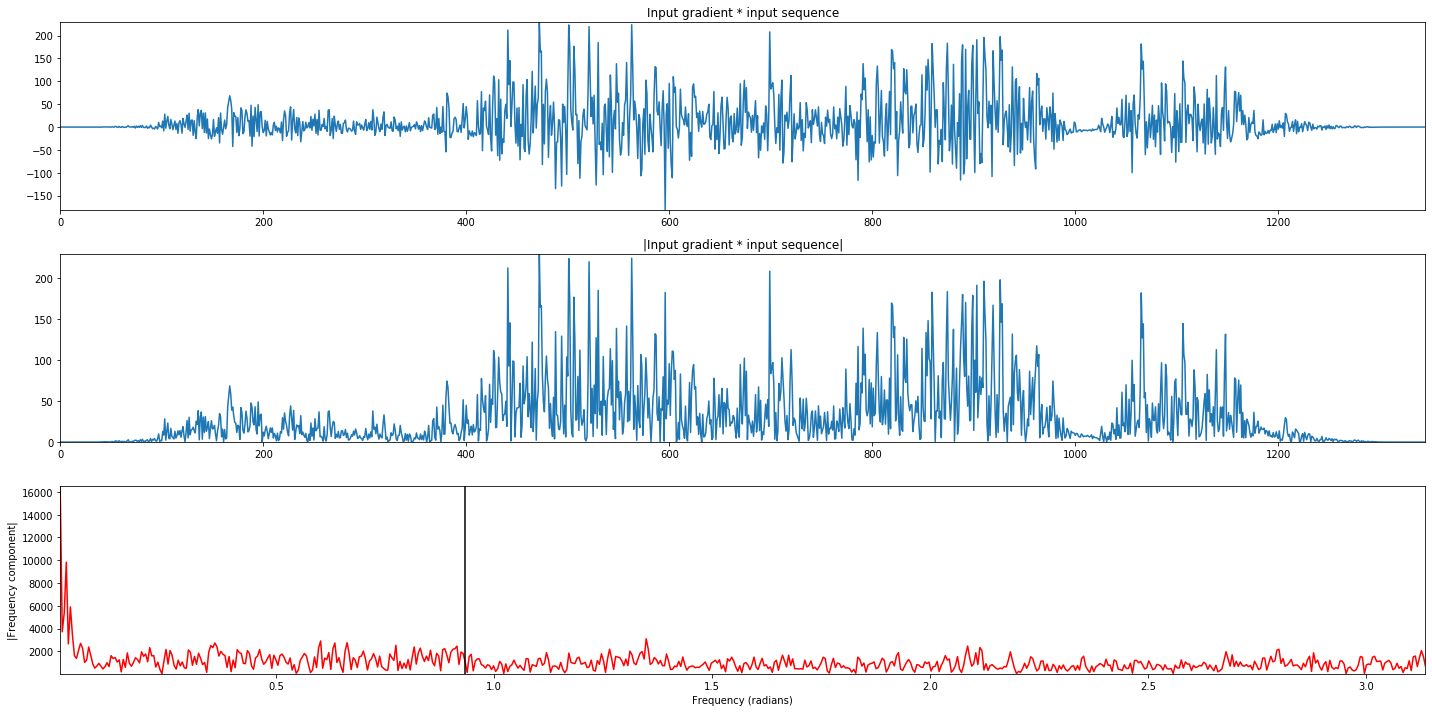

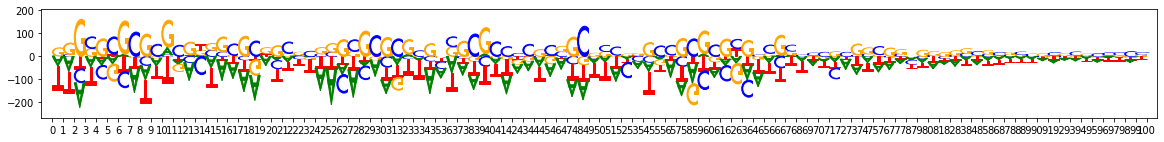

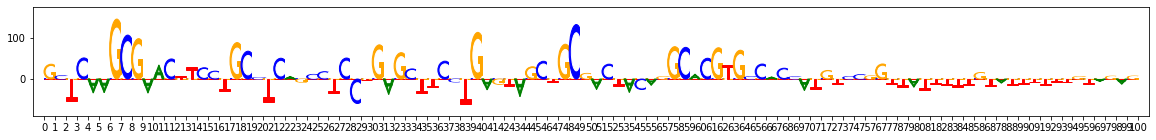

In [40]:
# E2F6
chrom, start, end = "chr10", 16436841, 16437171
seq_slice = slice(1100, 1200)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

Profile loss	Counts loss	Prior loss
150.495	 2.525	 0.144


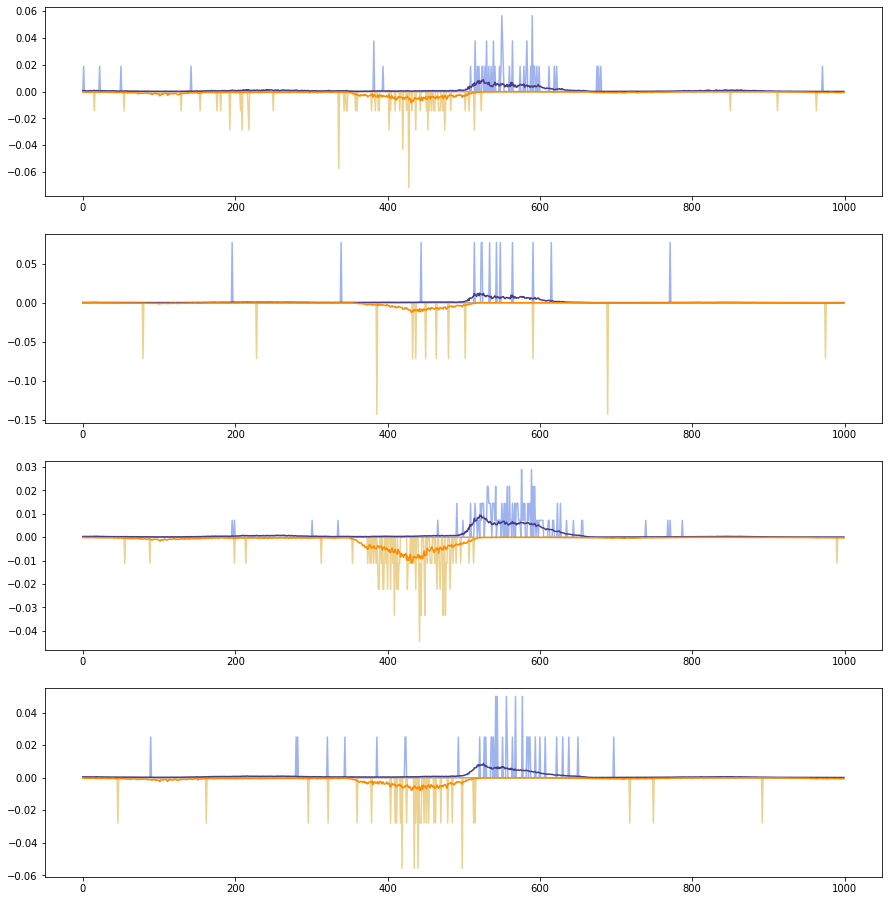

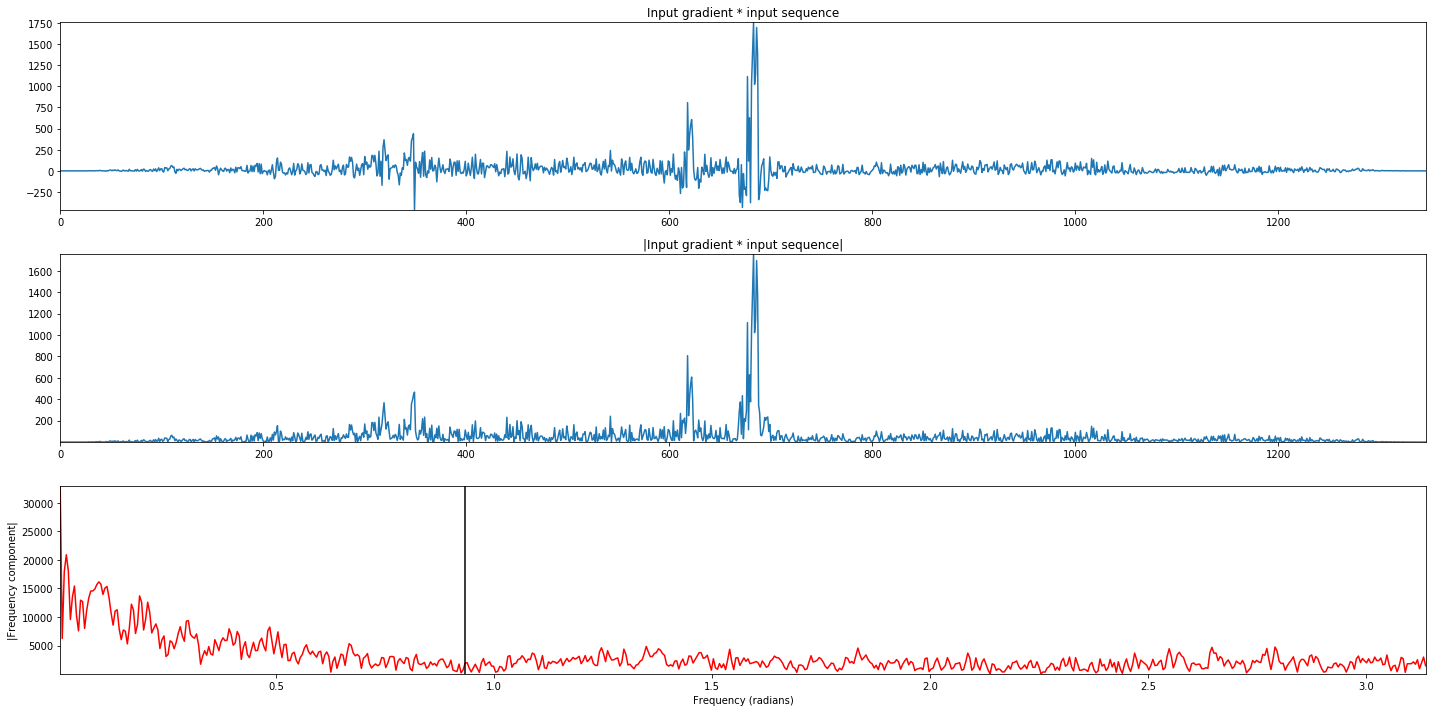

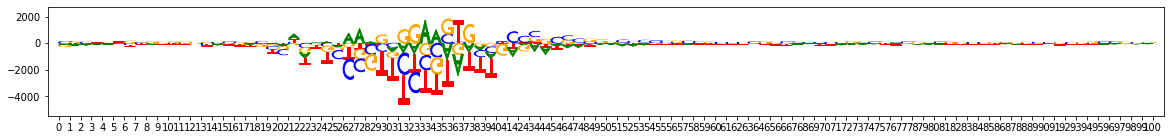

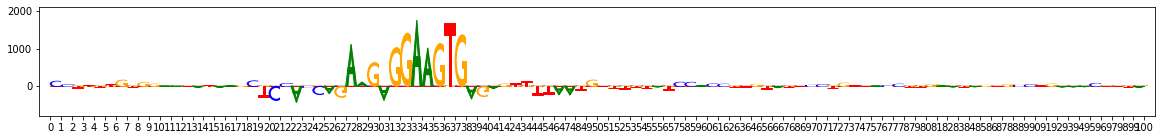

Profile loss	Counts loss	Prior loss
147.527	 2.437	 0.109


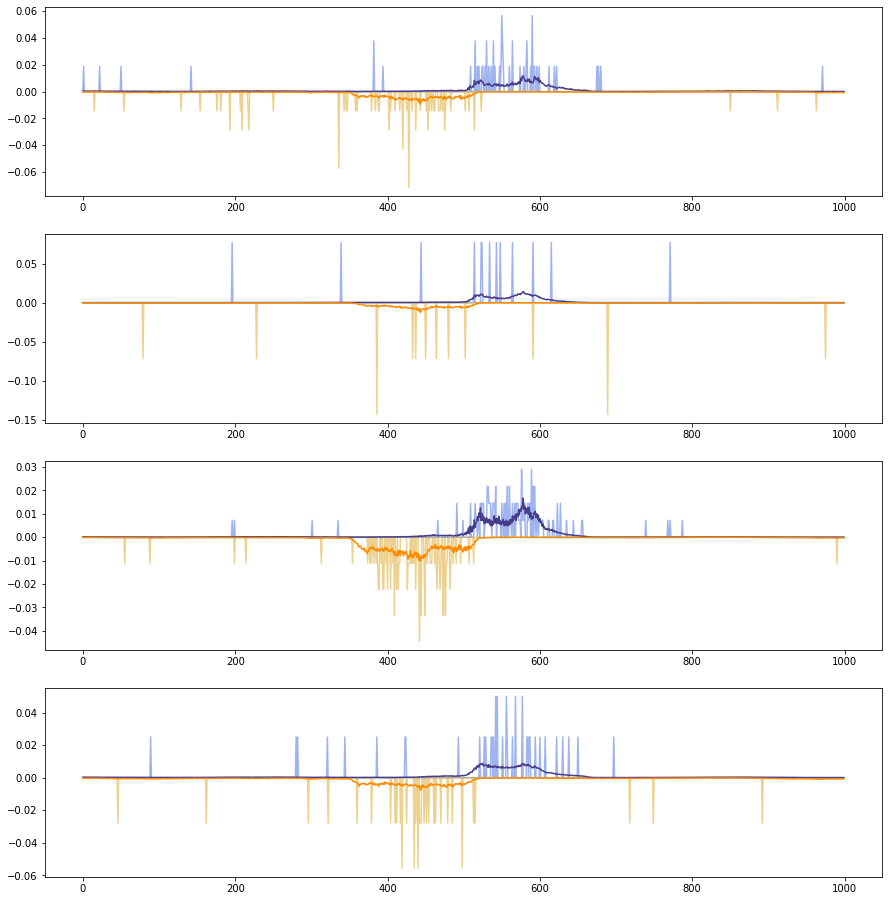

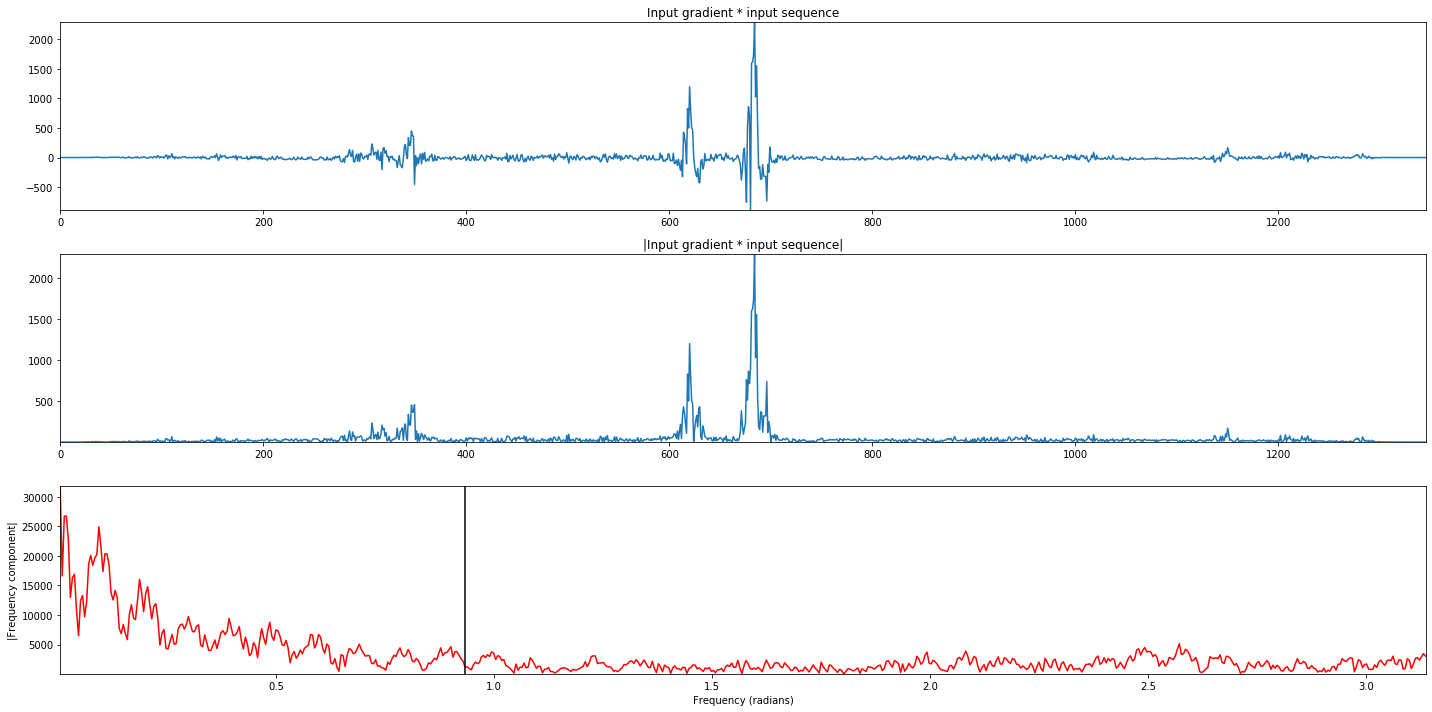

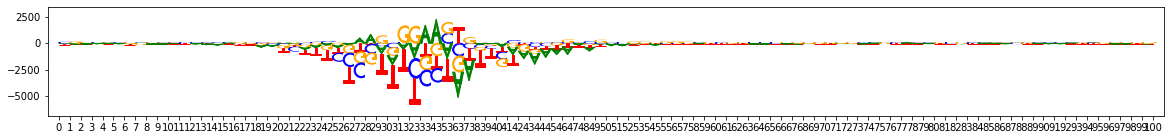

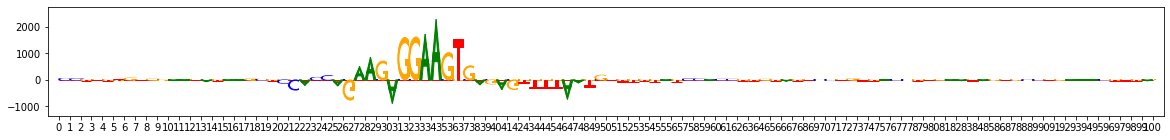

In [15]:
# SPI1
chrom, start, end = "chr10", 28542874, 28542975
seq_slice = slice(650, 750)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# K562
chrom, start, end = "chr8", 55961405, 55961688
seq_slice = slice(600, 700)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# K562
chrom, start, end = "chr10", 103917949, 103918705
seq_slice = slice(250, 350)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# K562
chrom, start, end = "chr8", 2814371, 2814780
seq_slice = slice(750, 800)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# HepG2
chrom, start, end = "chr10", 61903177, 61903588
seq_slice = slice(300, 400)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# HepG2
chrom, start, end = "chr10", 60305687, 60305902
seq_slice = slice(400, 500)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# HepG2
chrom, start, end = "chr10", 128069445, 128069658
seq_slice = slice(600, 700)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# HepG2
chrom, start, end = "chr8", 94642364, 94642575
seq_slice = slice(600, 700)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)

In [ ]:
# HepG2
chrom, start, end = "chr8", 477595, 477791
seq_slice = slice(650, 700)
predict_and_plot(noprior_model, chrom, start, end, seq_slice)
predict_and_plot(prior_model, chrom, start, end, seq_slice)